In [1]:
from collections import deque
import wave
import pyaudio
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as ncdf

### Head-related impulse responses

References:
- Brinkmann, Fabian et al.: The FABIAN head-related transfer function data base |
https://depositonce.tu-berlin.de/handle/11303/6153.5

In [2]:
# NOTE: Not supplied in the repo, download from the link above.
dataset = ncdf.Dataset('FABIAN_HRIR_measured_HATO_0.sofa', mode='r')

In [3]:
dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: SOFA
    Version: 1.0
    SOFAConventions: SimpleFreeFieldHRIR
    SOFAConventionsVersion: 1.0
    APIName: ARI SOFA API for Matlab/Octave
    APIVersion: 1.0.3
    ApplicationName: Matlab
    ApplicationVersion: 9.6.0.1072779 (R2019a)
    AuthorContact: fabian.brinkmann@tu-berlin.de
    Comment: Frequencies below 200 Hz, and HRIRs for elevations below -64 degree were substituted with numerically modeld HRIRs.
    DataType: FIR
    History: Original data set. DOI: 10.14279/depositonce-5718.4
    License: Creative Commons (CC-BY). Visit http://creativecommons.org/licenses/by/4.0/ for licence details.
    Organization: Audio Communication Group, TU Berlin, Germany (www.ak.tu-berlin.de)
    References: F. Brinkmann et al. (2017): "A High Resolution and Full-Spherical Head-Related Transfer Function Database for Different Head-Above-Torso Orientations." J. Audio Eng. Soc. 65(10):841-848. D

In [4]:
dataset.variables['Data.SamplingRate'][0]

masked_array(data=44100.,
             mask=False,
       fill_value=1e+20)

In [5]:
dataset.variables['SourcePosition']

<class 'netCDF4._netCDF4.Variable'>
float64 SourcePosition(M, C)
    Type: spherical
    Units: degree, degree, metre
unlimited dimensions: 
current shape = (11950, 3)
filling on, default _FillValue of 9.969209968386869e+36 used

In [6]:
points = np.array(dataset.variables['SourcePosition'])

In [7]:
# columns: azimuth, colatitude, quadrature weight
np.min(points[:,0]), np.max(points[:,0]), np.min(points[:,1]), np.max(points[:,1]), np.min(points[:,2]), np.max(points[:,2])

(0.0, 358.0, -90.0, 90.0, 1.7, 1.7)

In [8]:
plane_indices = np.where(np.isclose(points[:, 1], 0.))[0]

In [9]:
points2d = points[plane_indices, 0]

In [10]:
points2d.shape, np.min(points2d), np.max(points2d)

((180,), 0.0, 358.0)

In [11]:
dataset.variables['Data.IR']

<class 'netCDF4._netCDF4.Variable'>
float64 Data.IR(M, R, N)
unlimited dimensions: 
current shape = (11950, 2, 256)
filling on, default _FillValue of 9.969209968386869e+36 used

In [12]:
data = np.array(dataset.variables['Data.IR'])[plane_indices]

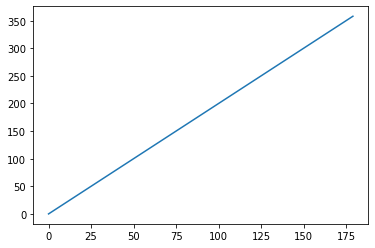

In [13]:
plt.plot(points2d);

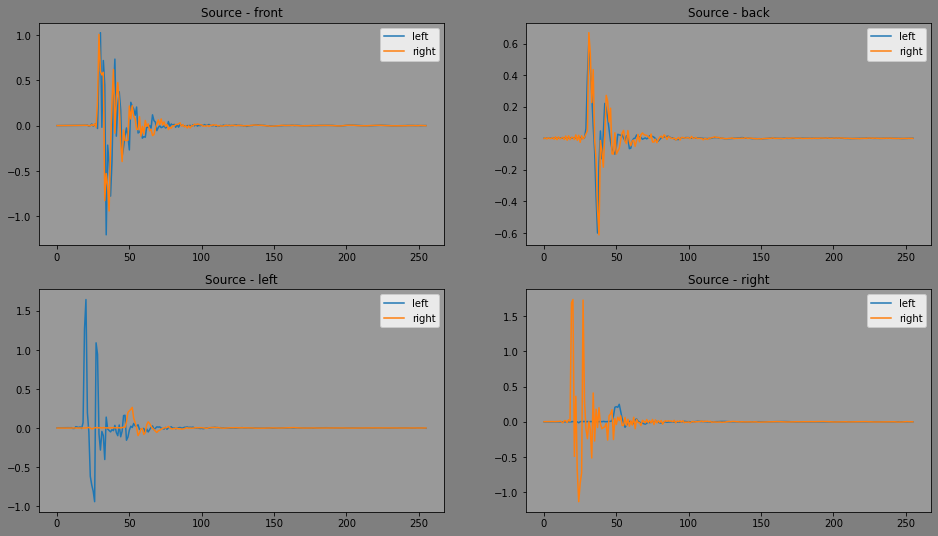

In [14]:
_, axes = plt.subplots(2,2,figsize=(16,9), facecolor='C7')

axes[0,0].plot(data[0, 0], label='left')
axes[0,0].plot(data[0, 1], label='right')
axes[0,0].legend()
axes[0,0].set_facecolor('#999999')
axes[0,0].set_title('Source - front')

axes[0,1].plot(data[180//2, 0], label='left')
axes[0,1].plot(data[180//2, 1], label='right')
axes[0,1].legend()
axes[0,1].set_facecolor('#999999')
axes[0,1].set_title('Source - back')

axes[1,0].plot(data[90//2, 0], label='left')
axes[1,0].plot(data[90//2, 1], label='right')
axes[1,0].legend()
axes[1,0].set_facecolor('#999999')
axes[1,0].set_title('Source - left')

axes[1,1].plot(data[270//2, 0], label='left')
axes[1,1].plot(data[270//2, 1], label='right')
axes[1,1].legend()
axes[1,1].set_facecolor('#999999')
axes[1,1].set_title('Source - right');

In [15]:
dataset.close()

### Convolution filtering

In [16]:
def play(left, right):
    """NOTE: Should be played over headphones."""

    tmp = np.empty(2*len(left), dtype=left.dtype)
    tmp[0::2] = left
    tmp[1::2] = right

    pa = pyaudio.PyAudio()

    stream = pa.open(
        rate=44100,
        channels=2,
        format=pa.get_format_from_width(2),
        output=True
    )

    stream.write(np.clip(tmp, -32768., 32767.).astype(np.int16).tobytes())

    stream.stop_stream()
    stream.close()
    pa.terminate()

In [17]:
data = np.load('../sidegame/assets/hrir2d.npy')

In [18]:
with wave.open('../sidegame/assets/sounds/rifle_t/ak47_01.wav', 'rb') as audio_stream:
    sound = np.frombuffer(audio_stream.readframes(audio_stream.getnframes()), dtype=np.int16).astype(np.float32)

left, right = sound[0::2], sound[1::2]

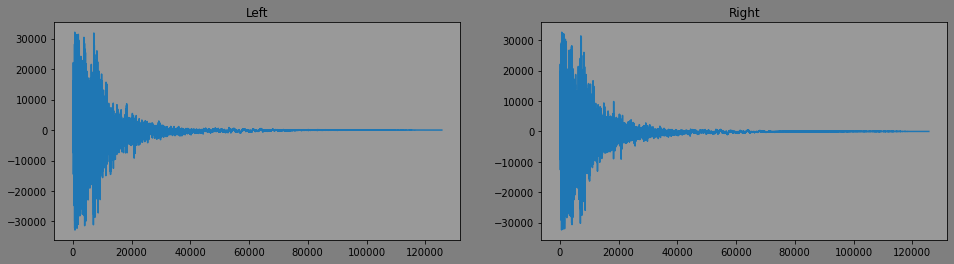

In [19]:
_, (ax1, ax2) = plt.subplots(1, 2, facecolor='C7', figsize=(16, 4))
ax1.set_facecolor('#999999')
ax2.set_facecolor('#999999')
ax1.set_title('Left')
ax2.set_title('Right')
ax1.plot(left)
ax2.plot(right);

In [20]:
cleft = np.convolve(left, data[0, 0])
cright = np.convolve(right, data[0, 1])

In [21]:
cleft.shape[0] - left.shape[0], data[0,0].shape

(255, (256,))

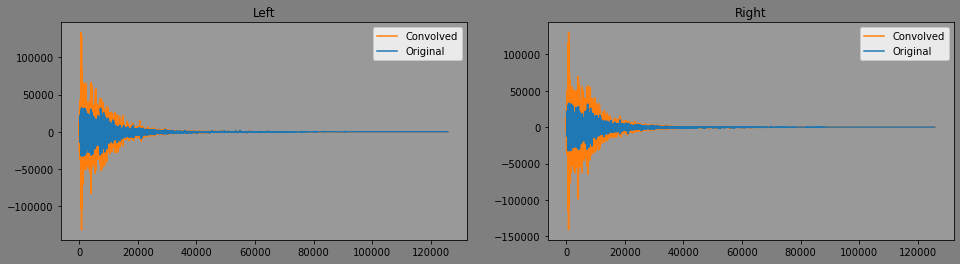

In [22]:
_, (ax1, ax2) = plt.subplots(1, 2, facecolor='C7', figsize=(16, 4))
ax1.set_facecolor('#999999')
ax2.set_facecolor('#999999')
ax1.set_title('Left')
ax2.set_title('Right')
ax1.plot(cleft, color='C1', label='Convolved')
ax2.plot(cright, color='C1', label='Convolved')
ax1.plot(np.arange(len(left))+128, left, label='Original')
ax2.plot(np.arange(len(left))+128, right, label='Original')
ax1.legend()
ax2.legend();

In [23]:
np.sum(data[0, 0])

0.9939530088417694

In [24]:
np.sum(np.abs(data[0, 0]))

11.661915361933673

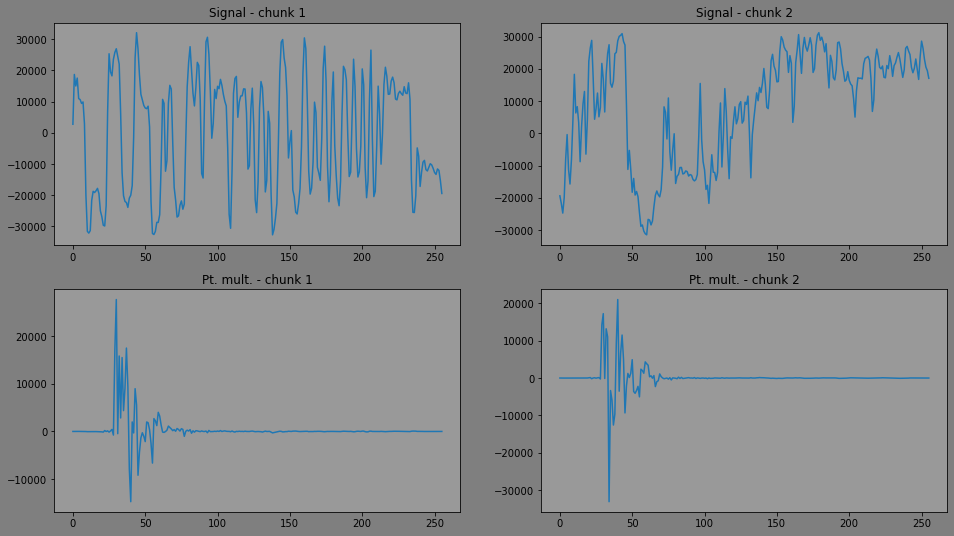

In [25]:
_, axes = plt.subplots(2, 2, facecolor='C7', figsize=(16, 9))

axes[0, 0].set_facecolor('#999999')
axes[0, 1].set_facecolor('#999999')
axes[1, 0].set_facecolor('#999999')
axes[1, 1].set_facecolor('#999999')

axes[0, 0].set_title('Signal - chunk 1')
axes[0, 1].set_title('Signal - chunk 2')
axes[1, 0].set_title('Pt. mult. - chunk 1')
axes[1, 1].set_title('Pt. mult. - chunk 2')

axes[0, 0].plot(left[850-256:850])
axes[0, 1].plot(left[850:850+256])
axes[1, 0].plot(left[850-256:850] * data[0, 0])
axes[1, 1].plot(left[850:850+256] * data[0, 0]);

In [26]:
np.sum(left[850-256:850] * data[0, 0]), np.sum(left[850:850+256] * data[0, 0])

(107118.49314300278, 33737.489633090256)

Note: While the HRIRs are normalised to sum to 1, the convolution result does not necessarily preserve the scale of the signal. If the signs of the values in the signal and filter align just right, they can cancel out and exceed the original scale.

Appropriate compensation of this behaviour seems to depend on the context:
- Compensating for the worst case in the above example would mean dividing the result by 11.66. Practically, the need for this is unrealistic and sound would be overly supressed.
- Compensating for the average case would, instead, involve a factor between 2 and 6. Some clipping could still occur, but the original and filtered sounds should mostly sound approximately equally loud.
- Instead of using a single factor, additional filtering steps could "naturally" balance amplitude (e.g. distance attenuation). This depends on the application and filtering functions would need to be carefully balanced.
- If sounds are downscaled before filtering (e.g. to leave space for sound summation) and amplitude mismatch is not a concern, occasional clipping could also be acceptable.

#### Source - front

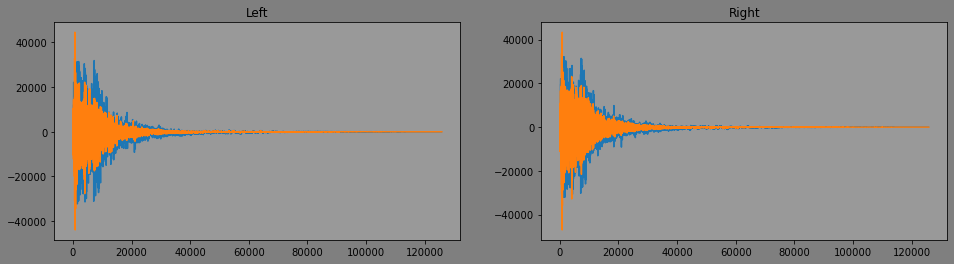

In [27]:
cleft = np.convolve(left, data[0, 0]) / 3.
cright = np.convolve(right, data[0, 1]) / 3.

_, (ax1, ax2) = plt.subplots(1, 2, facecolor='C7', figsize=(16, 4))
ax1.set_facecolor('#999999')
ax2.set_facecolor('#999999')
ax1.set_title('Left')
ax2.set_title('Right')
ax1.plot(np.arange(len(left))+128, left)
ax2.plot(np.arange(len(left))+128, right)
ax1.plot(cleft)
ax2.plot(cright);

In [28]:
play(left, right)

In [29]:
play(cleft, cright)

#### Source - back

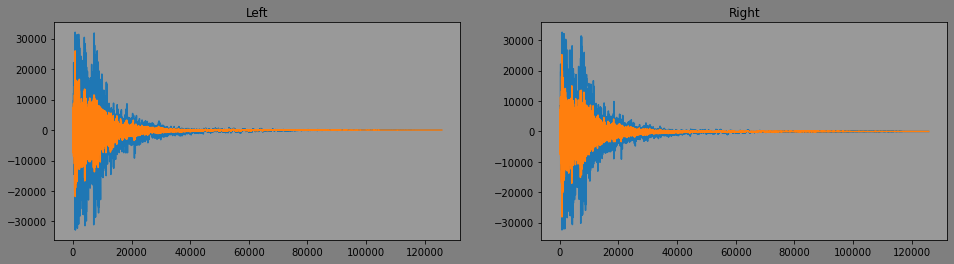

In [30]:
cleft = np.convolve(left, data[180//2, 0]) / 3.
cright = np.convolve(right, data[180//2, 1]) / 3.

_, (ax1, ax2) = plt.subplots(1, 2, facecolor='C7', figsize=(16, 4))
ax1.set_facecolor('#999999')
ax2.set_facecolor('#999999')
ax1.set_title('Left')
ax2.set_title('Right')
ax1.plot(np.arange(len(left))+128, left)
ax2.plot(np.arange(len(left))+128, right)
ax1.plot(cleft)
ax2.plot(cright);

In [31]:
play(cleft, cright)

#### Source - left

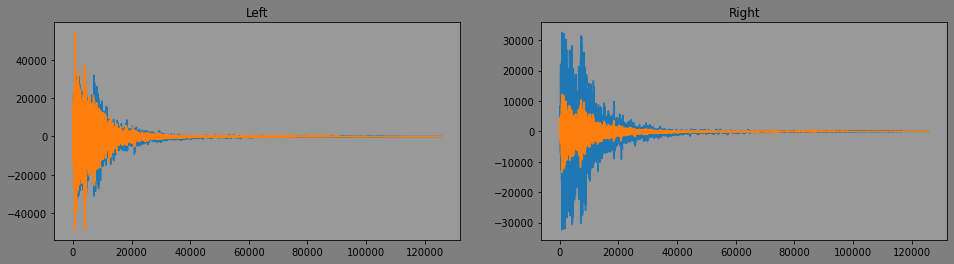

In [32]:
cleft = np.convolve(left, data[90//2, 0]) / 3.
cright = np.convolve(right, data[90//2, 1]) / 3.

_, (ax1, ax2) = plt.subplots(1, 2, facecolor='C7', figsize=(16, 4))
ax1.set_facecolor('#999999')
ax2.set_facecolor('#999999')
ax1.set_title('Left')
ax2.set_title('Right')
ax1.plot(np.arange(len(left))+128, left)
ax2.plot(np.arange(len(left))+128, right)
ax1.plot(cleft)
ax2.plot(cright);

In [33]:
play(cleft, cright)

#### Source - right

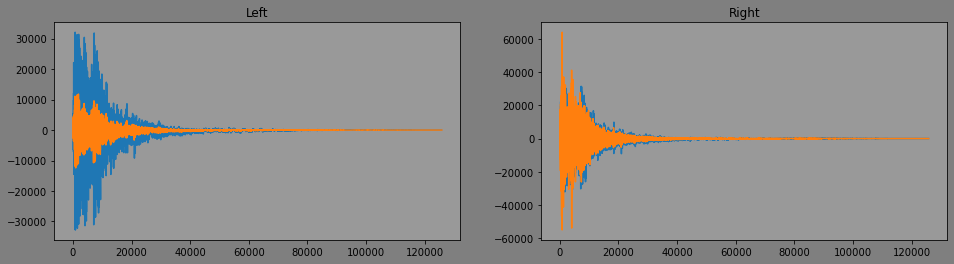

In [34]:
cleft = np.convolve(left, data[-90//2, 0]) / 3.
cright = np.convolve(right, data[-90//2, 1]) / 3.

_, (ax1, ax2) = plt.subplots(1,2,facecolor='C7', figsize=(16, 4))
ax1.set_facecolor('#999999')
ax2.set_facecolor('#999999')
ax1.set_title('Left')
ax2.set_title('Right')
ax1.plot(np.arange(len(left))+128, left)
ax2.plot(np.arange(len(left))+128, right)
ax1.plot(cleft)
ax2.plot(cright);

In [35]:
play(cleft, cright)

### Per partes convolution

In [36]:
lchunk, rchunk = left[5000-128:6470+127], right[5000-128:6470+127]
cleft = np.convolve(lchunk, data[0, 0], mode='valid') / 3.
cright = np.convolve(rchunk, data[0, 1], mode='valid') / 3.

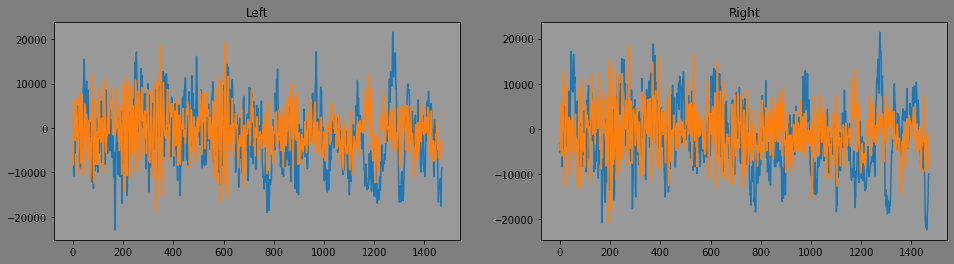

In [37]:
_, (ax1, ax2) = plt.subplots(1, 2, facecolor='C7', figsize=(16, 4))
ax1.set_facecolor('#999999')
ax2.set_facecolor('#999999')
ax1.set_title('Left')
ax2.set_title('Right')
ax1.plot(lchunk[128:-127])
ax2.plot(rchunk[128:-127])
ax1.plot(cleft)
ax2.plot(cright);

In [38]:
chunk_size = 1470
chunk_offset = 128

clefts = deque()
crights = deque()

pleft, pright = np.pad(left, (128, 127)), np.pad(right, (128, 127))

while chunk_offset < len(pleft) - 256:
    lchunk = pleft[chunk_offset-128:chunk_offset+chunk_size+127]
    rchunk = pright[chunk_offset-128:chunk_offset+chunk_size+127]
    
    clefts.append(lchunk)
    crights.append(rchunk)

    chunk_offset += chunk_size

clefts[0] = np.pad(clefts[0], (127, 0))
clefts[-1] = np.pad(clefts[-1], (0, 128))
crights[0] = np.pad(crights[0], (127, 0))
crights[-1] = np.pad(crights[-1], (0, 128))

for i in range(len(clefts)):
    clefts[i] = np.convolve(clefts[i], data[0, 0], mode='valid')
    crights[i] = np.convolve(crights[i], data[0, 1], mode='valid')

fcleft = np.concatenate(clefts)
fcright = np.concatenate(crights)

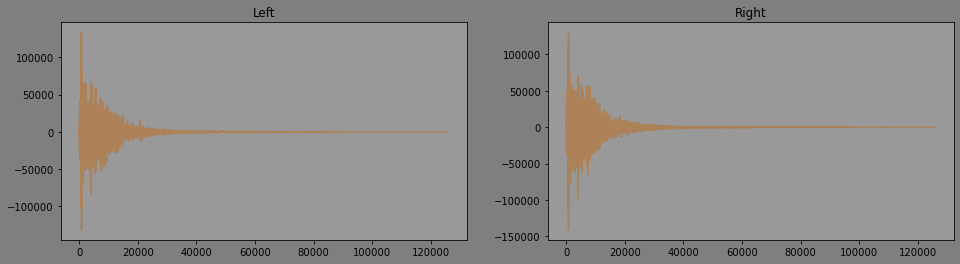

In [39]:
cleft = np.convolve(left, data[0, 0], mode='full')
cright = np.convolve(right, data[0, 1], mode='full')

_, (ax1, ax2) = plt.subplots(1, 2, facecolor='C7', figsize=(16, 4))
ax1.set_facecolor('#999999')
ax2.set_facecolor('#999999')
ax1.set_title('Left')
ax2.set_title('Right')
ax1.plot(cleft, alpha=0.5)
ax2.plot(cright, alpha=0.5)
ax1.plot(fcleft, alpha=0.5)
ax2.plot(fcright, alpha=0.5);

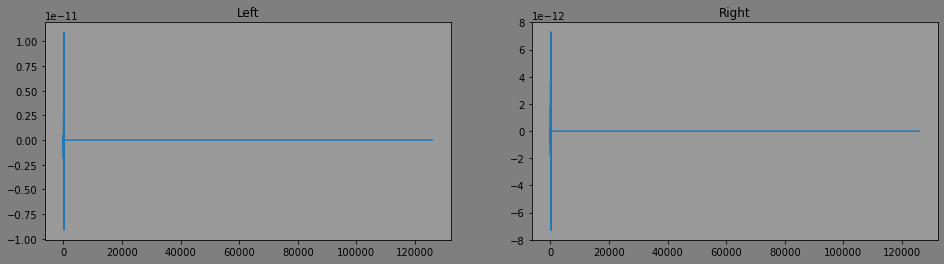

In [40]:
_, (ax1, ax2) = plt.subplots(1, 2, facecolor='C7', figsize=(16, 4))
ax1.set_facecolor('#999999')
ax2.set_facecolor('#999999')
ax1.set_title('Left')
ax2.set_title('Right')
ax1.plot(fcleft - cleft)
ax2.plot(fcright - cright);

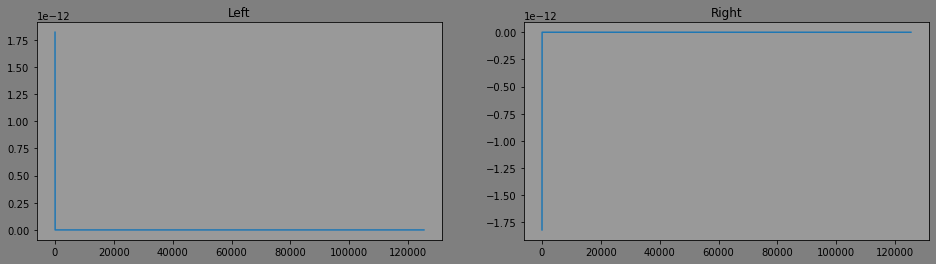

In [41]:
_, (ax1, ax2) = plt.subplots(1, 2, facecolor='C7', figsize=(16, 4))
ax1.set_facecolor('#999999')
ax2.set_facecolor('#999999')
ax1.set_title('Left')
ax2.set_title('Right')
ax1.plot(fcleft[254:-255] - cleft[254:-255])
ax2.plot(fcright[254:-255] - cright[254:-255]);

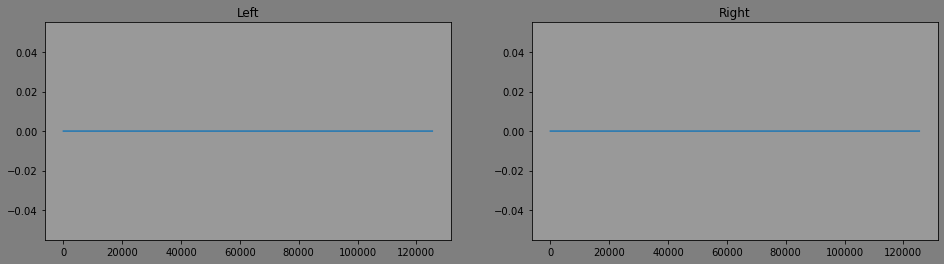

In [42]:
_, (ax1, ax2) = plt.subplots(1, 2, facecolor='C7', figsize=(16, 4))
ax1.set_facecolor('#999999')
ax2.set_facecolor('#999999')
ax1.set_title('Left')
ax2.set_title('Right')
ax1.plot(fcleft[255:-254] - cleft[255:-254])
ax2.plot(fcright[255:-254] - cright[255:-254]);

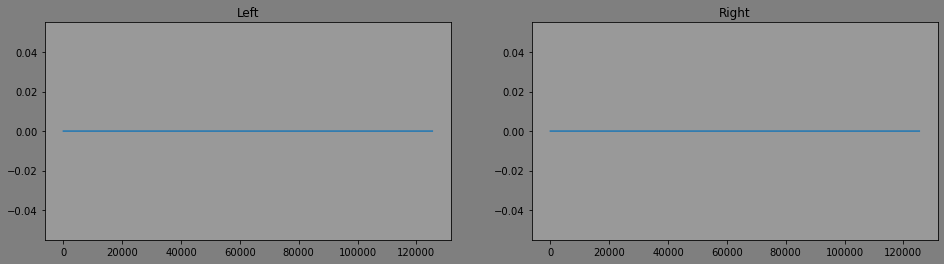

In [43]:
_, (ax1, ax2) = plt.subplots(1, 2, facecolor='C7', figsize=(16, 4))
ax1.set_facecolor('#999999')
ax2.set_facecolor('#999999')
ax1.set_title('Left')
ax2.set_title('Right')
ax1.plot(fcleft[255:-255] - cleft[255:-255])
ax2.plot(fcright[255:-255] - cright[255:-255]);

Note: Unsure why zero-padding makes the results slightly off, but the error is in the order of `10^-11` and limited to invalid parts, where the 256-length kernel overlaps with artificial padding. The valid part is consistent, implying functional equivalence and practical usability of the chunking approach.

### Distance attenuation

References:
- https://docs.unrealengine.com/en-US/WorkingWithMedia/Audio/DistanceModelAttenuation/index.html
- https://en.wikipedia.org/wiki/Sound_pressure#Inverse-proportional_law
- 3kliksphilip: The Bugged State of CS:GO's Sounds | https://www.youtube.com/watch?v=Cm0C-X8lHrs

In [44]:
# In metres
distances = [
    1., 1.25, 1.5, 2., 2.5, 3., 4., 5., 6., 7., 8., 9., 10., 12.5, 15., 17.5, 20., 22.5, 25., 30., 35., 45., 50.,
    60., 70., 80., 90., 100., 110.]

In [45]:
f = lambda x: 1./x
g = lambda x: np.exp(-0.05*x)
h = lambda x: 0.35/x + np.exp(-0.05*x)*0.65
g_ = lambda x: np.exp(-0.25*x**0.6)

In [46]:
# Amplitudes at pixel distance reference points
[g_(x * 108./512.) for x in [1., 10., 32., 54., 108., 216., 640.]]

[0.9064018179602246,
 0.6762245237982762,
 0.4555815662461461,
 0.340909094458991,
 0.19570979584601939,
 0.08438891975488447,
 0.008704180762306777]

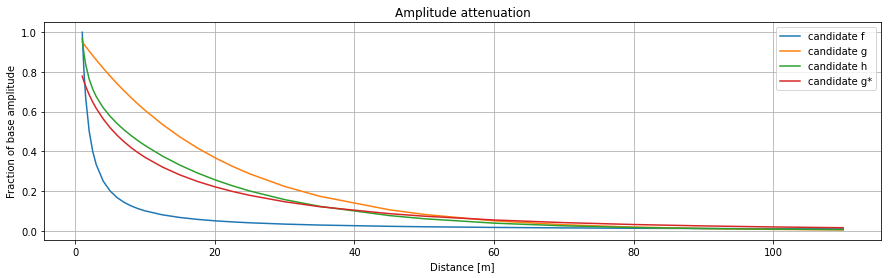

In [47]:
_, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(distances, [f(x) for x in distances], label='candidate f')
ax.plot(distances, [g(x) for x in distances], label='candidate g')
ax.plot(distances, [h(x) for x in distances], label='candidate h')
ax.plot(distances, [g_(x) for x in distances], label='candidate g*')
ax.grid()
ax.legend()
ax.set_ylabel('Fraction of base amplitude')
ax.set_xlabel('Distance [m]')
ax.set_title('Amplitude attenuation');

In [48]:
f = lambda x: 22050. - (22050.-500.)/109.*x
g = lambda x: 22050.*np.exp(-0.03*x)
g_ = lambda x: 22050.*np.exp(-0.01125*x**1.25)
g__ = lambda x: 100. + 21950.*np.exp(-0.004*x**1.55)

In [49]:
# Cut-off frequencies at pixel distance reference points
[g__(x * 108./512.) for x in [1., 10., 32., 54., 108., 216., 640.]]

[22042.132168492215,
 21772.557083690514,
 20419.71085394698,
 18550.723413577998,
 13300.4440629323,
 5051.760530085871,
 107.23054310987949]

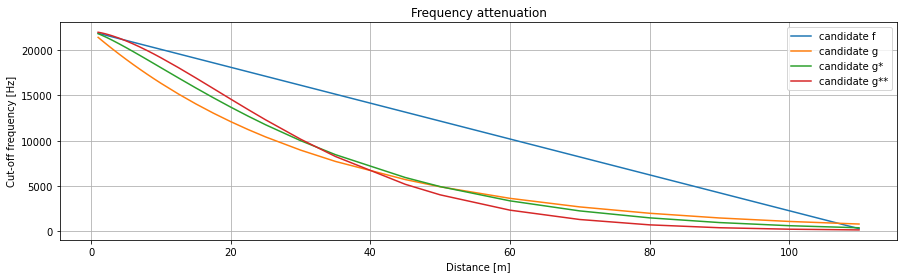

In [50]:
_, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(distances, [f(x) for x in distances], label='candidate f')
ax.plot(distances, [g(x) for x in distances], label='candidate g')
ax.plot(distances, [g_(x) for x in distances], label='candidate g*')
ax.plot(distances, [g__(x) for x in distances], label='candidate g**')
ax.grid()
ax.legend()
ax.set_ylabel('Cut-off frequency [Hz]')
ax.set_xlabel('Distance [m]')
ax.set_title('Frequency attenuation');